In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
import os

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import classification_report
from torch.utils.data.dataloader import default_collate

from datasets.syn_signs_loader import syn_signs
from models.gtsrb_cnn import GTSRB_CNN
from models.gtsrb_cnn_regular import GTSRB_CNN_regular

device = torch.device("cpu")
batch_size = 64
pin_memory = False

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    pin_memory = True

In [2]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((48, 48)),
                    # transforms.Normalize((0.5,), (0.5,)),
            ])

target_trainset = datasets.GTSRB(root = "./data", split = "train", download = True, transform = transform)
target_testset = datasets.GTSRB(root = "./data", split = "test", download = True, transform = transform)

In [3]:
# obtain training indices that will be used for validation
val_size = 0.2
num_train = len(target_trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(val_size * num_train))
split = 1280
train_index, val_index = indices[split:], indices[:split] # define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
val_sampler = SubsetRandomSampler(val_index)

target_trainloader = torch.utils.data.DataLoader(target_trainset, batch_size = batch_size
                                                    , num_workers = 2, sampler = train_sampler, pin_memory = pin_memory)
target_valloader = torch.utils.data.DataLoader(target_trainset, batch_size = batch_size
                                                    , num_workers = 2, sampler = val_sampler, pin_memory = pin_memory)
target_testloader = torch.utils.data.DataLoader(target_testset, batch_size = batch_size
                                                    , shuffle = True, num_workers = 2, pin_memory = pin_memory)

print("Target Train set size = %d, Val set size = %d, Test set size = %d" % (len(target_trainloader), 
                                                                      len(target_valloader), len(target_testloader)))

Target Train set size = 397, Val set size = 20, Test set size = 198


In [4]:
source_trainset = syn_signs(root = "./data/syn_signs/Images", transform = transform)

In [5]:
# obtain training indices that will be used for validation
val_size = 0.2
num_train = len(source_trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(val_size * num_train))
split = num_train - 100000
train_index, val_index = indices[split:], indices[:split] # define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
val_sampler = SubsetRandomSampler(val_index)

source_trainloader = torch.utils.data.DataLoader(source_trainset, batch_size = batch_size
                                                    , num_workers = 2, sampler = train_sampler, pin_memory = pin_memory)
source_valloader = torch.utils.data.DataLoader(source_trainset, batch_size = batch_size
                                                    , num_workers = 2, sampler = val_sampler, pin_memory = pin_memory)

print("Source Train set size = %d, Val set size = %d" % (len(source_trainloader), len(source_valloader)))

Source Train set size = 1563, Val set size = 353


Source Dataset


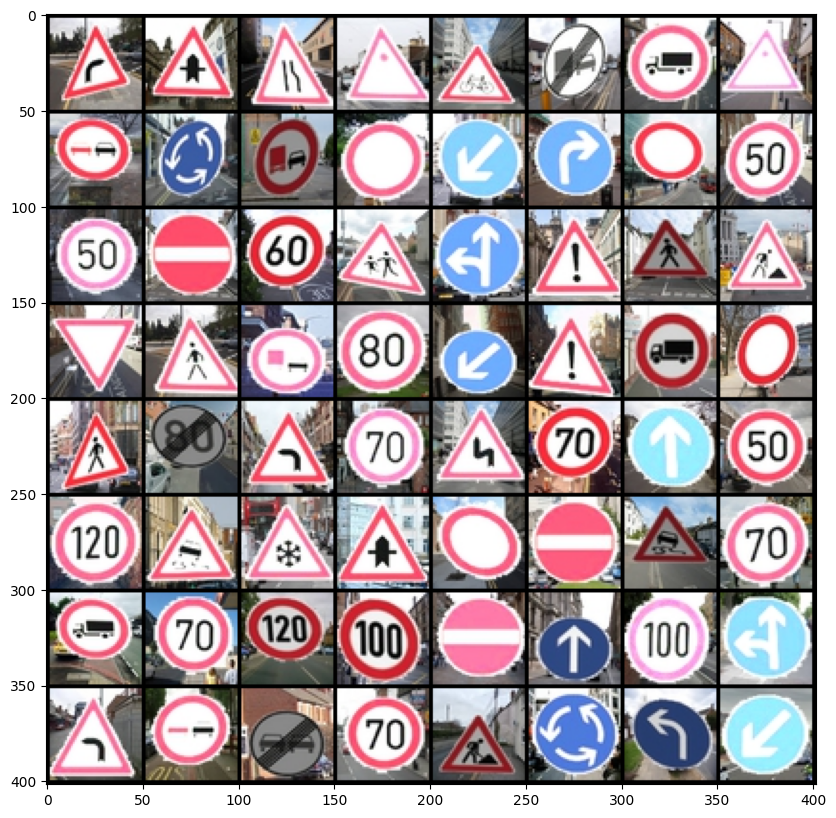

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target Dataset


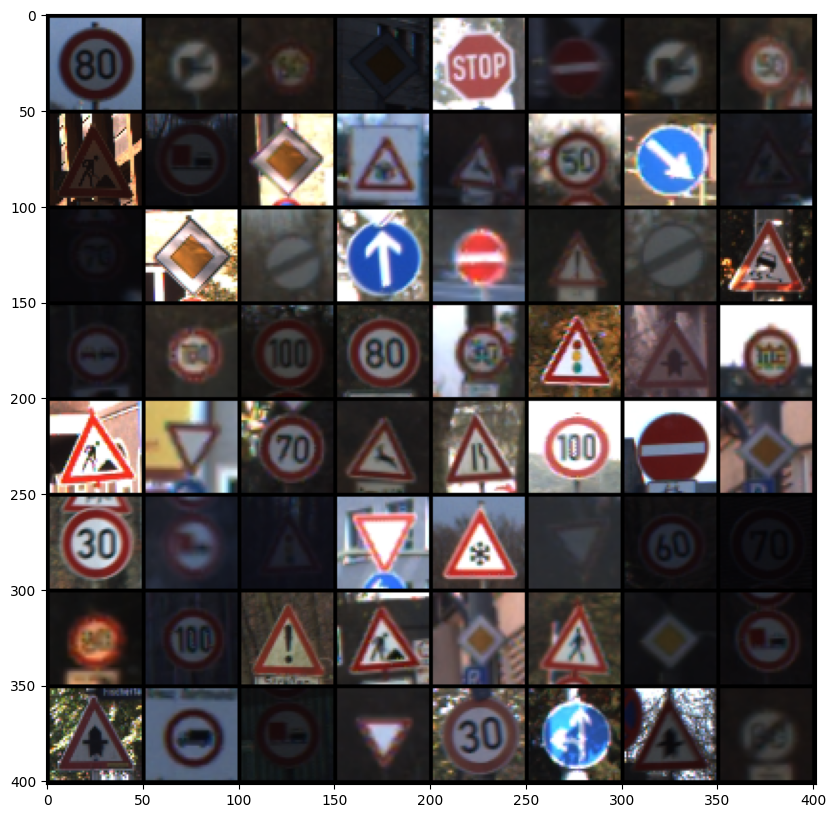

In [6]:
# let's have a look at the dataset
def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random source training images
dataiter = iter(source_trainloader)
images, labels = dataiter.__next__()

# show images
print("Source Dataset")
imshow(torchvision.utils.make_grid(images))

# get some random target training images
dataiter = iter(target_trainloader)
images, labels = dataiter.__next__()

# show images
print("Target Dataset")
imshow(torchvision.utils.make_grid(images))

In [7]:
def plot_loss(losses, title):
    plt.plot(range(len(losses)), losses)
    plt.title(title)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show()

In [8]:
def train(train_loaders, val_loaders, test_loader, model, optimizer, criteria, epochs = 25, model_save_path = "models/best_model.pt", scheduler = None):    
    train_losses = []
    train_source_label_losses = []
    train_source_domain_losses = []
    train_target_domain_losses = []
    val_losses = []
    val_source_label_losses = []
    val_target_label_losses = []
    min_val_loss = np.Inf
    
    lamda = 10
    lr0 = 0.01
    beta = 0.75

    model_save_dir = os.path.dirname(model_save_path)
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
    
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        len_dataloader = min(len(train_loaders[0]), len(train_loaders[1]))
        pbar = tqdm(total = len_dataloader, position = 0, leave = True)
       
        train_loss = 0
        train_source_label_loss = 0
        train_source_domain_loss = 0
        train_target_domain_loss = 0
        val_loss = 0
        val_source_label_loss = 0
        val_target_label_loss = 0
    
        source_iter = iter(train_loaders[0])
        target_iter = iter(train_loaders[1])
#         for batch_idx, (data, target) in enumerate(train_loaders[0]):
        for batch_idx in range(len_dataloader):
            source_data, source_labels = source_iter.__next__()
            target_data, target_labels = target_iter.__next__()
            
            p = float(batch_idx + epoch * len_dataloader) / (epochs * len_dataloader)
            alpha = (2. / (1. + np.exp(-lamda * p))) - 1
            for g in optimizer.param_groups:
                g["lr"] = lr0 / np.power((1 + lamda * p), beta)
            
            source_domain_labels = torch.zeros(source_data.shape[0], device = device)
            target_domain_labels = torch.ones(target_data.shape[0], device = device)

            # if torch.cuda.is_available():
            #     # print("Using CUDA")
            source_data, source_labels = source_data.to(device), source_labels.to(device)
            target_data, target_labels = target_data.to(device), target_labels.to(device)
            
            optimizer.zero_grad()
            source_classes, source_domains = model(source_data, alpha)
            label_loss = criteria[0](source_classes, source_labels)
            source_domain_loss = criteria[1](source_domains[:, 0], source_domain_labels)
            
            target_classes, target_domains = model(target_data, alpha)
            target_domain_loss = criteria[1](target_domains[:, 0], target_domain_labels)
            
            loss = label_loss + source_domain_loss + target_domain_loss
            loss.backward()
            optimizer.step()

            train_source_label_loss += label_loss.cpu().data.item() * source_labels.shape[0]
            train_source_domain_loss += source_domain_loss.cpu().data.item() * source_domain_labels.shape[0]
            train_target_domain_loss += target_domain_loss.cpu().data.item() * target_domain_labels.shape[0]
            train_loss += loss.cpu().data.item()
            pbar.update(1)
            pbar.desc= f'Train Loss: {loss.item()}'
            
        train_loss /= len_dataloader
        train_source_label_loss /= len_dataloader
        train_source_domain_loss /= len_dataloader
        train_target_domain_loss /= len_dataloader
        train_losses.append(train_loss)
        train_source_label_losses.append(train_source_label_loss)
        train_source_domain_losses.append(train_source_domain_loss)
        train_target_domain_losses.append(train_target_domain_loss)
        
        if scheduler is not None:
            scheduler.step()     
            
#         if train_loss < min_val_loss:
#             min_val_loss = train_loss
#             torch.save(model.state_dict(), model_save_path)

        model.eval()
        with torch.no_grad():
            len_val_dataloader = min(len(val_loaders[0]), len(val_loaders[1]))
            source_val_iter = iter(val_loaders[0])
            target_val_iter = iter(val_loaders[1])
            
            for batch_ix in range(len_val_dataloader):
                source_val_data, source_val_labels = source_val_iter.__next__()
                target_val_data, target_val_labels = target_val_iter.__next__()
                
                # if torch.cuda.is_available():
                source_val_data, source_val_labels = source_val_data.to(device), source_val_labels.to(device)
                target_val_data, target_val_labels = target_val_data.to(device), target_val_labels.to(device)

                source_pred_labels, source_pred_domains = model(source_val_data, alpha)
                source_label_loss = criteria[0](source_pred_labels, source_val_labels)          
                target_pred_labels, target_pred_domains = model(target_val_data, alpha)
                target_label_loss = criteria[0](target_pred_labels, target_val_labels)
                
                loss = source_label_loss + target_label_loss
                val_source_label_loss += source_label_loss.cpu().data.item() * source_val_data.shape[0]
                val_target_label_loss += target_label_loss.cpu().data.item() * target_val_data.shape[0]
                val_loss += loss.cpu().data.item()
                # source_label_loss.cpu().data.item() * source_val_data.shape[0] + target_label_loss.cpu().data.item() * target_val_data.shape[0]
                
            val_loss /= len_val_dataloader
            val_source_label_loss /= len_val_dataloader
            val_target_label_loss /= len_val_dataloader
            val_losses.append(val_loss)
            val_source_label_losses.append(val_source_label_loss)
            val_target_label_losses.append(val_target_label_loss)

        if val_loss < min_val_loss:
            print("Saving at epoch %d" % (epoch))
            min_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)
            
        print("Epoch %d: Train Loss = %f, Val Loss = %f" % (epoch, train_loss, val_loss))
        pbar.refresh()
        pbar.close()

    end_time = time.time()
    train_time = end_time - start_time
    
    plot_loss(train_losses, "Train Loss vs Epochs")
    plot_loss(train_source_label_losses, "Train Source Label Loss vs Epochs")
    plot_loss(train_source_domain_losses, "Train Source Domain Loss vs Epochs")
    plot_loss(train_target_domain_losses, "Train Target Domain Loss vs Epochs")
    plot_loss(val_losses, "Validation Loss vs Epochs")
    plot_loss(val_source_label_losses, "Validation Source Label Loss vs Epochs")
    plot_loss(val_target_label_losses, "Validation Target Label Loss vs Epochs")
    
#     start_time = time.time()
#     model.load_state_dict(torch.load(model_save_path))
#     get_model_size(model)
# #     train_report = evaluate(model, train_loader, criterion)
# #     test_report = evaluate(model, test_loader, criterion)
# #     end_time = time.time()
# #     eval_time = end_time - start_time
#     print("Training time = %f seconds" % (train_time))
# #     print("Evaluation time (on both, train and test sets) = %f seconds" % (eval_time))
            
# #     return train_report, test_report
    return None, None

Train Loss: 0.33133465051651:  99%|████████████████████████████████████████████████████▌| 394/397 [00:15<00:00, 28.56it/s]

Saving at epoch 0


Train Loss: 0.24148283898830414: 100%|██████████████████████████████████████████████████| 397/397 [00:16<00:00, 23.54it/s]


Epoch 0: Train Loss = 2.688936, Val Loss = 3.977199


Train Loss: 0.13656233251094818: 100%|██████████████████████████████████████████████████| 397/397 [00:15<00:00, 25.55it/s]

Saving at epoch 1


Train Loss: 0.26701608300209045: 100%|██████████████████████████████████████████████████| 397/397 [00:17<00:00, 23.08it/s]


Epoch 1: Train Loss = 0.272244, Val Loss = 3.712946


Train Loss: 0.33442604541778564: 100%|██████████████████████████████████████████████████| 397/397 [00:15<00:00, 26.39it/s]


Epoch 2: Train Loss = 0.211364, Val Loss = 4.358245


Train Loss: 0.5687925219535828:  99%|██████████████████████████████████████████████████▋| 395/397 [00:13<00:00, 31.56it/s]

Saving at epoch 3


Train Loss: 0.35077354311943054: 100%|██████████████████████████████████████████████████| 397/397 [00:14<00:00, 26.85it/s]


Epoch 3: Train Loss = 0.329641, Val Loss = 3.652035


Train Loss: 0.1876680701971054: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 30.51it/s]


Epoch 4: Train Loss = 0.333233, Val Loss = 3.961946


Train Loss: 0.3486993908882141: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.57it/s]


Epoch 5: Train Loss = 0.402989, Val Loss = 4.939184


Train Loss: 0.32101428508758545: 100%|██████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.89it/s]


Epoch 6: Train Loss = 0.619595, Val Loss = 4.646980


Train Loss: 0.8956358432769775: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.20it/s]


Epoch 7: Train Loss = 0.526137, Val Loss = 5.746806


Train Loss: 0.8919103145599365: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.31it/s]


Epoch 8: Train Loss = 0.723927, Val Loss = 5.673285


Train Loss: 1.0734741687774658: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.91it/s]


Epoch 9: Train Loss = 0.822956, Val Loss = 7.076478


Train Loss: 1.1187154054641724: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 32.56it/s]


Epoch 10: Train Loss = 0.900351, Val Loss = 9.199349


Train Loss: 0.9286801218986511: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 33.03it/s]


Epoch 11: Train Loss = 0.926810, Val Loss = 5.530542


Train Loss: 1.2626285552978516: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 30.19it/s]


Epoch 12: Train Loss = 0.981087, Val Loss = 7.320061


Train Loss: 0.806786060333252: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 30.14it/s]


Epoch 13: Train Loss = 1.063339, Val Loss = 4.377075


Train Loss: 1.224606990814209: 100%|████████████████████████████████████████████████████| 397/397 [00:10<00:00, 43.91it/s]

Saving at epoch 14


Train Loss: 1.2258682250976562: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.97it/s]


Epoch 14: Train Loss = 1.099818, Val Loss = 3.589160


Train Loss: 1.1419833898544312: 100%|███████████████████████████████████████████████████| 397/397 [00:10<00:00, 36.27it/s]


Epoch 15: Train Loss = 1.115447, Val Loss = 5.626645


Train Loss: 1.5863837003707886: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.57it/s]


Epoch 16: Train Loss = 1.155908, Val Loss = 6.730608


Train Loss: 1.250633716583252: 100%|████████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.46it/s]


Epoch 17: Train Loss = 1.233183, Val Loss = 4.758637


Train Loss: 1.3071486949920654: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.88it/s]


Epoch 18: Train Loss = 1.219235, Val Loss = 5.730667


Train Loss: 1.321094274520874: 100%|████████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.36it/s]


Epoch 19: Train Loss = 1.238527, Val Loss = 8.187805


Train Loss: 1.0801993608474731: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.54it/s]


Epoch 20: Train Loss = 1.206624, Val Loss = 5.655115


Train Loss: 1.2907335758209229: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.65it/s]


Epoch 21: Train Loss = 1.209900, Val Loss = 5.780983


Train Loss: 1.0470843315124512: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 35.46it/s]


Epoch 22: Train Loss = 1.175724, Val Loss = 5.143206


Train Loss: 1.4324467182159424: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.31it/s]


Epoch 23: Train Loss = 1.231734, Val Loss = 4.651868


Train Loss: 1.3300912380218506: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 32.68it/s]


Epoch 24: Train Loss = 1.240745, Val Loss = 5.800938


Train Loss: 1.2466306686401367: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.73it/s]


Epoch 25: Train Loss = 1.251614, Val Loss = 7.123757


Train Loss: 1.315946102142334: 100%|████████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.44it/s]


Epoch 26: Train Loss = 1.225140, Val Loss = 5.073367


Train Loss: 1.335450530052185: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 32.09it/s]


Epoch 27: Train Loss = 1.223389, Val Loss = 7.789086


Train Loss: 1.5162973403930664: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.18it/s]


Epoch 28: Train Loss = 1.239220, Val Loss = 5.318368


Train Loss: 1.3793327808380127: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.08it/s]


Epoch 29: Train Loss = 1.237092, Val Loss = 5.953368


Train Loss: 1.251462459564209: 100%|████████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.52it/s]


Epoch 30: Train Loss = 1.237266, Val Loss = 5.179001


Train Loss: 1.261238694190979: 100%|████████████████████████████████████████████████████| 397/397 [00:11<00:00, 35.54it/s]


Epoch 31: Train Loss = 1.302779, Val Loss = 5.531402


Train Loss: 1.4473876953125: 100%|██████████████████████████████████████████████████████| 397/397 [00:12<00:00, 32.96it/s]


Epoch 32: Train Loss = 1.319593, Val Loss = 4.390391


Train Loss: 1.4145691394805908: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.21it/s]


Epoch 33: Train Loss = 1.334185, Val Loss = 4.832553


Train Loss: 1.1811211109161377: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 32.78it/s]


Epoch 34: Train Loss = 1.353949, Val Loss = 5.238822


Train Loss: 1.2597075700759888: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.78it/s]


Epoch 35: Train Loss = 1.337538, Val Loss = 5.198997


Train Loss: 1.341534972190857: 100%|████████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.39it/s]


Epoch 36: Train Loss = 1.339570, Val Loss = 5.132220


Train Loss: 1.340062141418457: 100%|████████████████████████████████████████████████████| 397/397 [00:15<00:00, 26.32it/s]


Epoch 37: Train Loss = 1.346214, Val Loss = 5.666166


Train Loss: 1.3707566261291504: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.99it/s]


Epoch 38: Train Loss = 1.325688, Val Loss = 5.668231


Train Loss: 1.264801263809204: 100%|████████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.68it/s]


Epoch 39: Train Loss = 1.341727, Val Loss = 4.947936


Train Loss: 1.2112987041473389: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.75it/s]


Epoch 40: Train Loss = 1.335320, Val Loss = 4.864829


Train Loss: 1.364640712738037: 100%|████████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.80it/s]


Epoch 41: Train Loss = 1.341790, Val Loss = 4.201642


Train Loss: 1.3129379749298096: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 35.07it/s]


Epoch 42: Train Loss = 1.346730, Val Loss = 5.542639


Train Loss: 1.281327247619629: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 32.01it/s]


Epoch 43: Train Loss = 1.353613, Val Loss = 4.735337


Train Loss: 1.3087782859802246: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.86it/s]


Epoch 44: Train Loss = 1.348694, Val Loss = 5.629305


Train Loss: 1.4062838554382324: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.98it/s]


Epoch 45: Train Loss = 1.346110, Val Loss = 4.990386


Train Loss: 1.2853814363479614: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.85it/s]


Epoch 46: Train Loss = 1.341960, Val Loss = 4.770142


Train Loss: 1.3730921745300293: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.78it/s]


Epoch 47: Train Loss = 1.348430, Val Loss = 5.124384


Train Loss: 1.4072544574737549: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.89it/s]


Epoch 48: Train Loss = 1.353982, Val Loss = 5.424202


Train Loss: 1.4369847774505615: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 32.55it/s]


Epoch 49: Train Loss = 1.351273, Val Loss = 5.059086


Train Loss: 1.3326263427734375: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.32it/s]


Epoch 50: Train Loss = 1.361955, Val Loss = 5.487495


Train Loss: 1.3126815557479858: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 32.72it/s]


Epoch 51: Train Loss = 1.366648, Val Loss = 5.077708


Train Loss: 1.2844696044921875: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.77it/s]


Epoch 52: Train Loss = 1.365870, Val Loss = 4.887589


Train Loss: 1.3479965925216675: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.79it/s]


Epoch 53: Train Loss = 1.364299, Val Loss = 5.295171


Train Loss: 1.3813586235046387: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.59it/s]


Epoch 54: Train Loss = 1.355622, Val Loss = 4.916326


Train Loss: 1.2649202346801758: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.52it/s]


Epoch 55: Train Loss = 1.359426, Val Loss = 5.088215


Train Loss: 1.4833488464355469: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.60it/s]


Epoch 56: Train Loss = 1.348217, Val Loss = 6.179430


Train Loss: 1.454785943031311: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 32.31it/s]


Epoch 57: Train Loss = 1.372831, Val Loss = 6.692341


Train Loss: 1.3935034275054932: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.57it/s]


Epoch 58: Train Loss = 1.372524, Val Loss = 6.065229


Train Loss: 1.3716152906417847: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.96it/s]


Epoch 59: Train Loss = 1.366621, Val Loss = 6.287584


Train Loss: 1.4286491870880127: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.31it/s]


Epoch 60: Train Loss = 1.362140, Val Loss = 6.767897


Train Loss: 1.4275538921356201: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.86it/s]


Epoch 61: Train Loss = 1.367120, Val Loss = 5.036389


Train Loss: 1.419752836227417: 100%|████████████████████████████████████████████████████| 397/397 [00:11<00:00, 35.46it/s]


Epoch 62: Train Loss = 1.370032, Val Loss = 5.289347


Train Loss: 1.355421543121338: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.99it/s]


Epoch 63: Train Loss = 1.368825, Val Loss = 4.515101


Train Loss: 1.3540830612182617: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.56it/s]


Epoch 64: Train Loss = 1.364769, Val Loss = 5.884870


Train Loss: 1.356750726699829: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 30.35it/s]


Epoch 65: Train Loss = 1.373116, Val Loss = 6.128583


Train Loss: 1.398468017578125: 100%|████████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.89it/s]


Epoch 66: Train Loss = 1.365824, Val Loss = 4.585161


Train Loss: 1.3347408771514893: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.79it/s]


Epoch 67: Train Loss = 1.374680, Val Loss = 4.357314


Train Loss: 1.3584790229797363: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 32.01it/s]


Epoch 68: Train Loss = 1.373077, Val Loss = 3.895761


Train Loss: 1.3552546501159668: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.97it/s]


Epoch 69: Train Loss = 1.373697, Val Loss = 4.453672


Train Loss: 1.4302456378936768: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 35.47it/s]


Epoch 70: Train Loss = 1.379677, Val Loss = 4.388845


Train Loss: 1.3765684366226196: 100%|███████████████████████████████████████████████████| 397/397 [00:17<00:00, 22.81it/s]


Epoch 71: Train Loss = 1.379417, Val Loss = 4.620531


Train Loss: 1.3864079713821411: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 30.93it/s]


Epoch 72: Train Loss = 1.378462, Val Loss = 4.484816


Train Loss: 1.3481236696243286: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.66it/s]


Epoch 73: Train Loss = 1.373076, Val Loss = 4.675292


Train Loss: 1.3570857048034668: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.75it/s]


Epoch 74: Train Loss = 1.372020, Val Loss = 5.912771


Train Loss: 1.3390347957611084: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.91it/s]


Epoch 75: Train Loss = 1.373131, Val Loss = 4.467106


Train Loss: 1.3401141166687012: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.75it/s]


Epoch 76: Train Loss = 1.376100, Val Loss = 5.929105


Train Loss: 1.3828200101852417: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.97it/s]


Epoch 77: Train Loss = 1.377024, Val Loss = 6.139775


Train Loss: 1.3372578620910645: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.22it/s]


Epoch 78: Train Loss = 1.369297, Val Loss = 4.593451


Train Loss: 1.4077038764953613: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 33.00it/s]


Epoch 79: Train Loss = 1.359443, Val Loss = 5.271129


Train Loss: 1.3731319904327393: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 32.98it/s]


Epoch 80: Train Loss = 1.366872, Val Loss = 4.839875


Train Loss: 1.3809034824371338: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 35.29it/s]


Epoch 81: Train Loss = 1.363622, Val Loss = 4.959013


Train Loss: 1.4207481145858765: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.61it/s]


Epoch 82: Train Loss = 1.371962, Val Loss = 5.170959


Train Loss: 1.3161866664886475: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.36it/s]


Epoch 83: Train Loss = 1.368095, Val Loss = 5.387369


Train Loss: 1.3917243480682373: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.75it/s]


Epoch 84: Train Loss = 1.369306, Val Loss = 5.505242


Train Loss: 1.3827483654022217: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.13it/s]


Epoch 85: Train Loss = 1.362682, Val Loss = 4.473382


Train Loss: 1.3718783855438232: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.76it/s]


Epoch 86: Train Loss = 1.373500, Val Loss = 4.225364


Train Loss: 1.4561185836791992: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.77it/s]


Epoch 87: Train Loss = 1.375045, Val Loss = 4.671464


Train Loss: 1.337900161743164: 100%|████████████████████████████████████████████████████| 397/397 [00:11<00:00, 35.01it/s]


Epoch 88: Train Loss = 1.372178, Val Loss = 4.746959


Train Loss: 1.3391942977905273: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.42it/s]


Epoch 89: Train Loss = 1.367257, Val Loss = 5.231077


Train Loss: 1.3120217323303223: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.18it/s]


Epoch 90: Train Loss = 1.372285, Val Loss = 5.598141


Train Loss: 1.385387659072876: 100%|████████████████████████████████████████████████████| 397/397 [00:11<00:00, 33.82it/s]


Epoch 91: Train Loss = 1.376609, Val Loss = 5.860345


Train Loss: 1.3654937744140625: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.29it/s]


Epoch 92: Train Loss = 1.378460, Val Loss = 5.636292


Train Loss: 1.37611722946167: 100%|█████████████████████████████████████████████████████| 397/397 [00:13<00:00, 30.10it/s]


Epoch 93: Train Loss = 1.377573, Val Loss = 4.937173


Train Loss: 1.3380330801010132: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.25it/s]


Epoch 94: Train Loss = 1.375179, Val Loss = 4.865315


Train Loss: 1.3877578973770142: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.46it/s]


Epoch 95: Train Loss = 1.380609, Val Loss = 5.751685


Train Loss: 1.3936150074005127: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.50it/s]


Epoch 96: Train Loss = 1.377301, Val Loss = 5.127059


Train Loss: 1.3580639362335205: 100%|███████████████████████████████████████████████████| 397/397 [00:11<00:00, 34.35it/s]


Epoch 97: Train Loss = 1.376894, Val Loss = 4.795330


Train Loss: 1.368818759918213: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 32.07it/s]


Epoch 98: Train Loss = 1.374541, Val Loss = 5.487651


Train Loss: 1.3750267028808594: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 32.54it/s]

Epoch 99: Train Loss = 1.375963, Val Loss = 4.991717


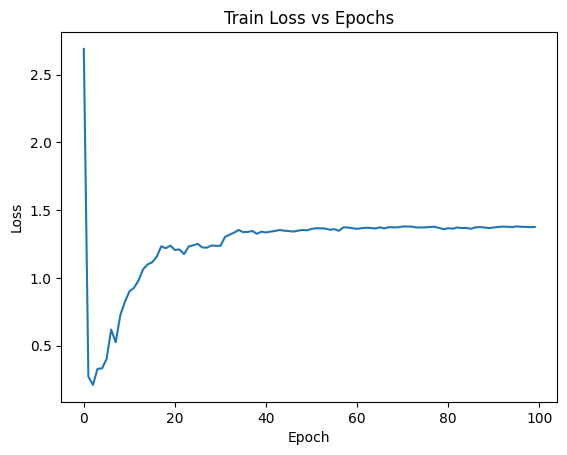

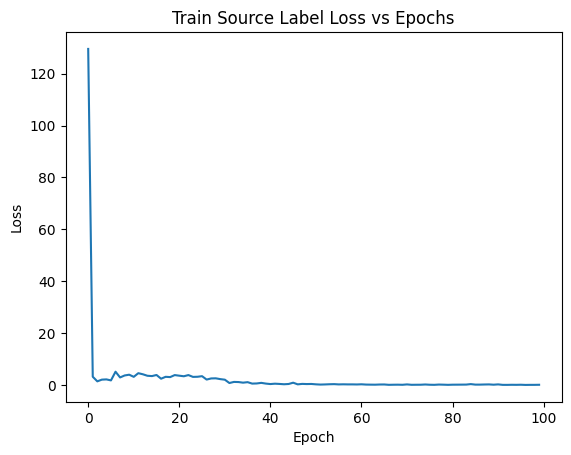

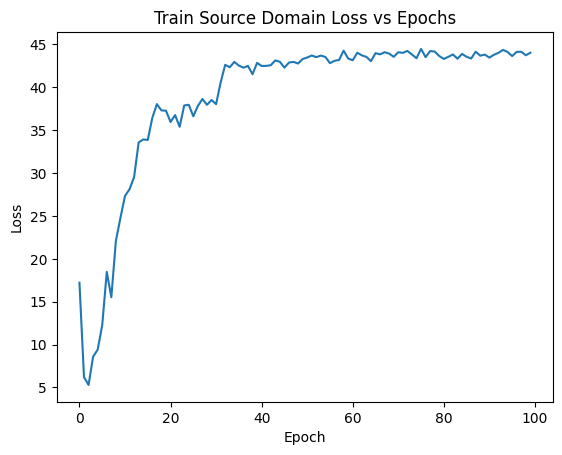

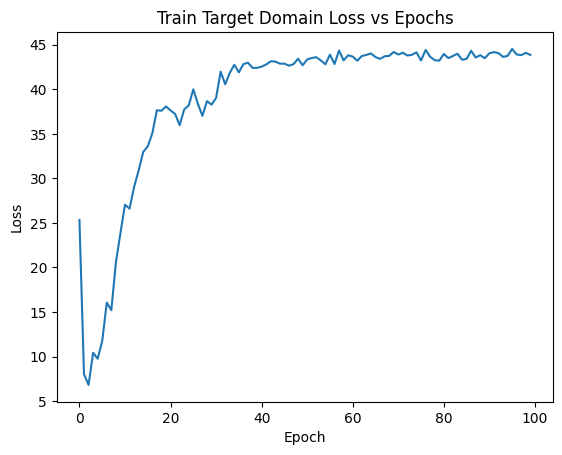

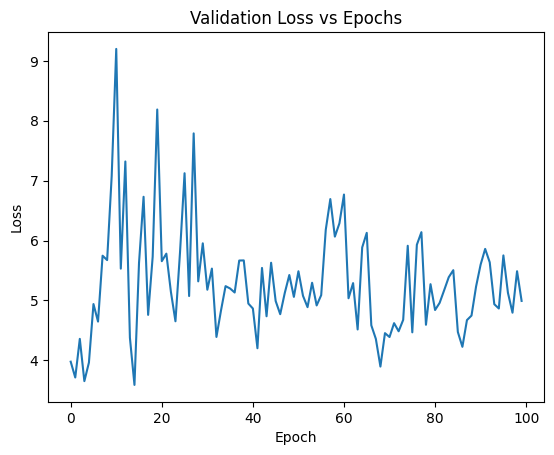

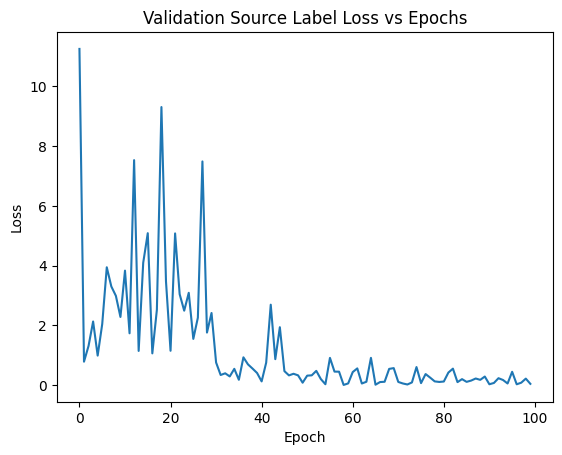

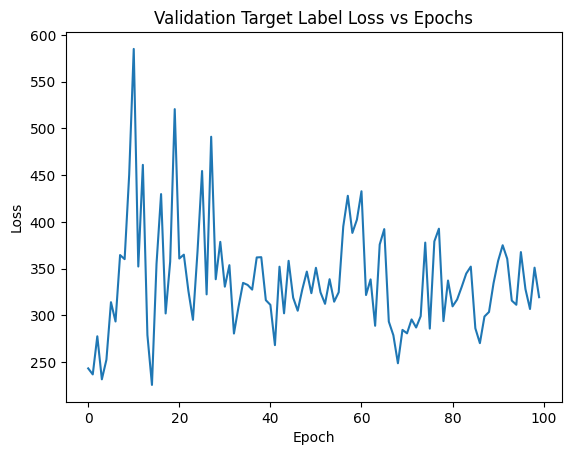

In [9]:
lr = 0.01
model = GTSRB_CNN().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
# criteria = [nn.NLLLoss(), nn.BCELoss()]
criteria = [nn.CrossEntropyLoss(), nn.BCELoss()]
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)
scheduler = None

train_report, test_report = train([source_trainloader, target_trainloader], [source_valloader, target_valloader], 
                                  target_testloader, model, optimizer, criteria, 100, 
                                  "checkpoints/gtsrb/gtsrb_sgd_mom_0_9_lr_0_01_anneal_cross_entropy_img.pt", scheduler)

In [ ]:
def evaluate(model, target_valloader, domain_adaptation = True):
    preds_labels = []
    preds_domains = []
    gt_labels = []
    model = model.cpu()

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(target_valloader):
            # data.to(device)
            # target.to(device)

            if domain_adaptation:
                pred_labels, pred_domains = model(data, 1.)
                pred_domains = np.round(np.array(pred_domains))
                preds_domains.append(pred_domains)
            
            else:
                pred_labels = model(data, 1.)
                
            # pred_labels = np.argmax(np.exp(np.array(pred_labels)), axis = 1)
            softmax = torch.nn.Softmax()
            pred_labels = np.argmax(np.array(softmax(pred_labels)), axis = 1)
            
            preds_labels.append(pred_labels)
            gt_labels.append(np.array(target))

    preds_labels = np.array(preds_labels).reshape(-1)
    gt_labels = np.array(gt_labels).reshape(-1)    
    print("Class Label Report")
    print(classification_report(preds_labels, gt_labels))
    
    if domain_adaptation:
        preds_domains = np.array(preds_domains).reshape(-1)
        gt_domains = np.ones(gt_labels.shape)
        print("Domain Label Report")
        print(classification_report(preds_domains, gt_domains))

In [10]:
model = GTSRB_CNN().to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_sgd_mom_0_9_lr_0_01_anneal_cross_entropy.pt"
model.load_state_dict(torch.load(model_save_path))
evaluate(model, target_valloader)

Class Label Report
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         6
           1       0.33      1.00      0.49        24
           2       0.10      0.58      0.16        12
           3       0.15      0.62      0.24        13
           4       0.21      0.67      0.32        18
           5       0.08      0.20      0.11        25
           6       0.36      0.06      0.10        82
           7       0.35      0.27      0.31        55
           8       0.04      0.08      0.05        26
           9       0.26      1.00      0.41        10
          10       0.31      0.55      0.40        38
          11       0.42      0.95      0.58        19
          12       0.71      0.47      0.57       100
          13       0.45      1.00      0.62        28
          14       0.88      0.45      0.59        49
          15       0.25      0.10      0.14        40
          16       0.73      1.00      0.84         8
        

### Source Only Model

In [13]:
def train(train_loader, val_loader, test_loader, model, optimizer, criterion, epochs = 25, model_save_path = "models/best_model.pt", scheduler = None):
    train_losses = []
    val_losses = []
    min_val_loss = np.Inf

    model_save_dir = os.path.dirname(model_save_path)
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
    
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        pbar = tqdm(total = len(train_loader), position = 0, leave = True)
        train_loss = 0
        val_loss = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            out = model(data, 1.)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.cpu().data.item() * data.size(0)
            pbar.update(1)
            pbar.desc= f'Train Loss: {loss.item()}'

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        if scheduler is not None:
            scheduler.step()
            
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_loader):
                data, target = data.to(device), target.to(device)
                
                out = model(data, 1.)
                loss = criterion(out, target)
                val_loss += loss.cpu().data.item() * data.size(0)
                
            val_loss /= len(val_loader)
            val_losses.append(val_loss)

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)
            
        print("Epoch %d: Train Loss = %f, Val Loss = %f" % (epoch, train_loss, val_loss))
        pbar.refresh()
        pbar.close()

    end_time = time.time()
    train_time = end_time - start_time
    
    plot_loss(train_losses, "Train Loss vs Epochs")
    plot_loss(val_losses, "Validation Loss vs Epochs")
    
#     start_time = time.time()
#     model.load_state_dict(torch.load(model_save_path))
#     get_model_size(model)
# #     train_report = evaluate(model, train_loader, criterion)
# #     test_report = evaluate(model, test_loader, criterion)
# #     end_time = time.time()
# #     eval_time = end_time - start_time
#     print("Training time = %f seconds" % (train_time))
# #     print("Evaluation time (on both, train and test sets) = %f seconds" % (eval_time))
            
# #     return train_report, test_report
    return None, None

In [ ]:
lr = 0.01
source_only_model = GTSRB_CNN(False).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
optimizer = torch.optim.SGD(source_only_model.parameters(), lr = lr, momentum = 0.9)
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)
scheduler = None

train_report, test_report = train(source_trainloader, source_valloader, 
                                  target_testloader, source_only_model, optimizer, criterion, 100, 
                                  "checkpoints/gtsrb/gtsrb_batchnorm_source_only.pt", scheduler)

Train Loss: 0.0024903430603444576: 100%|██████████████████████████████████████████████| 1563/1563 [01:38<00:00, 15.90it/s]


Epoch 0: Train Loss = 32.931171, Val Loss = 0.569650


Train Loss: 0.00017920773825608194: 100%|█████████████████████████████████████████████| 1563/1563 [00:46<00:00, 33.95it/s]


Epoch 1: Train Loss = 0.285198, Val Loss = 0.205973


Train Loss: 4.8209836677415296e-05: 100%|█████████████████████████████████████████████| 1563/1563 [00:48<00:00, 32.40it/s]


Epoch 2: Train Loss = 0.132608, Val Loss = 0.350648


Train Loss: 1.596590482222382e-05: 100%|██████████████████████████████████████████████| 1563/1563 [00:40<00:00, 38.88it/s]


Epoch 3: Train Loss = 0.099685, Val Loss = 0.176684


Train Loss: 1.98891921172617e-05: 100%|███████████████████████████████████████████████| 1563/1563 [00:41<00:00, 37.38it/s]


Epoch 4: Train Loss = 0.057797, Val Loss = 0.111110


Train Loss: 8.753174188314006e-05: 100%|██████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.31it/s]


Epoch 5: Train Loss = 0.035462, Val Loss = 0.083456


Train Loss: 2.4144084818544798e-05: 100%|█████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.17it/s]


Epoch 6: Train Loss = 0.019812, Val Loss = 0.070732


Train Loss: 1.3379064512264449e-05:  96%|███████████████████████████████████████████  | 1496/1563 [00:31<00:01, 48.05it/s]

In [18]:
model = GTSRB_CNN_regular().to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_batchnorm_source_only.pt"
model.load_state_dict(torch.load(model_save_path))
evaluate(model, target_valloader, False)

Class Label Report with Source Only Model
              precision    recall  f1-score   support

           0       0.62      0.71      0.67         7
           1       0.36      1.00      0.53        32
           2       0.46      0.62      0.52        60
           3       0.15      0.89      0.26         9
           4       0.29      0.77      0.42        22
           5       0.11      0.58      0.18        12
           6       0.13      1.00      0.24         2
           7       0.40      0.61      0.48        23
           8       0.13      0.78      0.23         9
           9       0.62      0.78      0.69        32
          10       0.41      0.59      0.48        41
          11       0.76      0.83      0.79        46
          12       0.77      0.86      0.81        50
          13       0.87      0.77      0.82        75
          14       1.00      0.47      0.64        47
          15       0.88      0.29      0.43        80
          16       0.69      0.32      

### Target Only Model

In [19]:
lr = 0.01
target_only_model = GTSRB_CNN_regular().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
criterion = nn.NLLLoss()
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)
scheduler = None

train_report, test_report = train(target_trainloader, target_valloader, 
                                  target_testloader, target_only_model, optimizer, criterion, 100, 
                                  "checkpoints/gtsrb/gtsrb_target_only.pt", scheduler)

Train Loss: 3.832033157348633: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 26.52it/s]


Epoch 0: Train Loss = 248.022822, Val Loss = 249.647551


Train Loss: 3.9858036041259766: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.48it/s]


Epoch 1: Train Loss = 248.004986, Val Loss = 249.630782


Train Loss: 3.7528181076049805: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.54it/s]


Epoch 2: Train Loss = 247.985008, Val Loss = 249.397615


Train Loss: 3.764519214630127: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.83it/s]


Epoch 3: Train Loss = 248.057811, Val Loss = 249.602704


Train Loss: 3.974313974380493: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.34it/s]


Epoch 4: Train Loss = 248.030832, Val Loss = 248.896324


Train Loss: 3.866891384124756: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.09it/s]


Epoch 5: Train Loss = 248.017369, Val Loss = 248.732826


Train Loss: 3.86167573928833: 100%|█████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.60it/s]


Epoch 6: Train Loss = 247.991791, Val Loss = 248.763101


Train Loss: 3.878621816635132: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.64it/s]


Epoch 7: Train Loss = 247.992012, Val Loss = 249.244251


Train Loss: 4.058420181274414: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.48it/s]


Epoch 8: Train Loss = 248.000075, Val Loss = 248.526698


Train Loss: 3.9000861644744873: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.66it/s]


Epoch 9: Train Loss = 248.008682, Val Loss = 248.966019


Train Loss: 3.6887221336364746: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.70it/s]


Epoch 10: Train Loss = 248.006719, Val Loss = 249.773577


Train Loss: 3.9617414474487305: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 30.85it/s]


Epoch 11: Train Loss = 248.006198, Val Loss = 248.949530


Train Loss: 3.8399617671966553: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.71it/s]


Epoch 12: Train Loss = 248.039940, Val Loss = 249.469141


Train Loss: 3.9327242374420166: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.64it/s]


Epoch 13: Train Loss = 248.068053, Val Loss = 248.889617


Train Loss: 3.888753652572632: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.84it/s]


Epoch 14: Train Loss = 247.972612, Val Loss = 248.671022


Train Loss: 3.7534101009368896: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.99it/s]


Epoch 15: Train Loss = 248.038289, Val Loss = 249.003996


Train Loss: 3.932107448577881: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.24it/s]


Epoch 16: Train Loss = 248.058021, Val Loss = 249.218332


Train Loss: 3.812154769897461: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.79it/s]


Epoch 17: Train Loss = 248.051381, Val Loss = 249.860588


Train Loss: 3.7990188598632812: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.41it/s]


Epoch 18: Train Loss = 248.050103, Val Loss = 248.464185


Train Loss: 3.7566781044006348: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.78it/s]


Epoch 19: Train Loss = 248.089010, Val Loss = 249.456346


Train Loss: 3.8910155296325684: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.77it/s]


Epoch 20: Train Loss = 248.050161, Val Loss = 248.614005


Train Loss: 3.8667330741882324: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.65it/s]


Epoch 21: Train Loss = 248.074577, Val Loss = 248.880694


Train Loss: 3.869363307952881: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.05it/s]


Epoch 22: Train Loss = 248.028492, Val Loss = 248.798869


Train Loss: 3.714935779571533: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.87it/s]


Epoch 23: Train Loss = 248.117814, Val Loss = 248.948489


Train Loss: 4.036585807800293: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.92it/s]


Epoch 24: Train Loss = 248.003044, Val Loss = 249.803053


Train Loss: 3.8678805828094482: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.71it/s]


Epoch 25: Train Loss = 248.065760, Val Loss = 249.704687


Train Loss: 3.8403916358947754: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.67it/s]


Epoch 26: Train Loss = 248.038146, Val Loss = 248.754916


Train Loss: 3.886875867843628: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.21it/s]


Epoch 27: Train Loss = 248.012516, Val Loss = 249.661125


Train Loss: 3.9091031551361084: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.55it/s]


Epoch 28: Train Loss = 248.039474, Val Loss = 248.241342


Train Loss: 3.896815776824951: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.95it/s]


Epoch 29: Train Loss = 248.032454, Val Loss = 249.197712


Train Loss: 3.99359130859375: 100%|█████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.90it/s]


Epoch 30: Train Loss = 248.029272, Val Loss = 249.559791


Train Loss: 3.8486852645874023: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.60it/s]


Epoch 31: Train Loss = 248.064928, Val Loss = 248.524183


Train Loss: 4.068630695343018: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.09it/s]


Epoch 32: Train Loss = 248.047591, Val Loss = 249.138504


Train Loss: 3.6870710849761963: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.51it/s]


Epoch 33: Train Loss = 248.072041, Val Loss = 249.365769


Train Loss: 4.020301342010498: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.67it/s]


Epoch 34: Train Loss = 248.053698, Val Loss = 249.521062


Train Loss: 3.788384437561035: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.65it/s]


Epoch 35: Train Loss = 248.050929, Val Loss = 248.537782


Train Loss: 4.1122870445251465: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.80it/s]


Epoch 36: Train Loss = 248.056244, Val Loss = 249.432095


Train Loss: 3.826587200164795:  35%|█████████████████▉                                  | 137/397 [00:04<00:07, 34.97it/s]Exception in thread Thread-136:
Traceback (most recent call last):
  File "/home2/shaurya.dewan/miniconda3/envs/nerf_test/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home2/shaurya.dewan/miniconda3/envs/nerf_test/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home2/shaurya.dewan/miniconda3/envs/nerf_test/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 51, in _pin_memory_loop
    do_one_step()
  File "/home2/shaurya.dewan/miniconda3/envs/nerf_test/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home2/shaurya.dewan/miniconda3/envs/nerf_test/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "/ho

KeyboardInterrupt: 

In [20]:
model = GTSRB_CNN_regular().to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_target_only.pt"
model.load_state_dict(torch.load(model_save_path))
preds_labels = []
gt_labels = []
model = model.cpu()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(target_valloader):
        # data.to(device)
        # target.to(device)
            
        pred_labels = model(data)
        pred_labels = np.argmax(np.exp(np.array(pred_labels)), axis = 1)
        
        preds_labels.append(pred_labels)
        gt_labels.append(np.array(target))
        
preds_labels = np.array(preds_labels).reshape(-1)
gt_labels = np.array(gt_labels).reshape(-1)

print("Class Label Report with Target Only Model")
print(classification_report(preds_labels, gt_labels))

Class Label Report with Target Only Model
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.02      0.22      0.04         9
           3       0.02      0.01      0.01       158
           4       0.25      0.07      0.11       214
           5       0.02      0.09      0.03        11
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00        33
           8       0.00      0.00      0.00         3
           9       0.03      0.02      0.02        56
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         4
          16       0.00      0.00      

Train Loss: 3.8682522773742676:  35%|█████████████████▋                                 | 138/397 [00:15<00:07, 34.97it/s]